# Are embeddings radial in the mean of the time series?

A hypothesis from browsing the data is that the further the point is from origo the larger the values are. We will test that in this notebook.

## Calculating mean of each time series

In [28]:
from electricity.data import ElectricityDataSet
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

dataset = ElectricityDataSet(
    "electricity/data/electricity.npy",
    include_time_covariates=False,
    start_date="2012-06-01",
    end_date="2014-12-18",
    predict_ahead=1,
    h_batch=0,
    one_hot_id=False,
)

data_loader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
iterloader = iter(data_loader)
d = iterloader.next()
len(d)

Dimension of X :  torch.Size([370, 1, 22344])
Dimension of Y :  torch.Size([370, 1, 22344])


4

In [29]:
ts_means = {}
for i, d in enumerate(data_loader):
    x, y, idx, idx_row = d[0], d[1], d[2], d[3]
    mean_ts = np.mean(x.detach().numpy())
    ts_means[idx_row.item()] = mean_ts

In [52]:
df_mean = pd.DataFrame.from_dict(data=ts_means.items())
df_mean.columns = ["id", "mean"]
df_mean.head()

,id,mean
0,0,18.256435
1,1,112.321655
2,2,8.244424
3,3,438.900208
4,4,195.882401


## Getting the embeddings and their radius

In [48]:
from electricity.model import TCN
import torch

model = TCN(
    num_layers=6,
    in_channels=1,
    out_channels=1,
    residual_blocks_channel_size=[32] * 5 + [1],
    kernel_size=7,
    dropout=0.2,
    leveledinit= False,
    num_embeddings= 370,
    embedding_dim= 3,
    embed = "post",
    )

model.load_state_dict(torch.load("electricity\models\embeddings_test_post.pt", map_location=torch.device("cpu")))
model.eval()

TCN(
  (tcn): TemporalConvolutionalNetwork(
    (net): Sequential(
      (0): ResidualBlock(
        (dcc1): DilatedCausalConv(1, 32, kernel_size=(7,), stride=(1,))
        (drop1): Dropout(p=0.2, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(7,), stride=(1,))
        (drop2): Dropout(p=0.2, inplace=False)
        (res_conv): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
      )
      (1): ResidualBlock(
        (dcc1): DilatedCausalConv(32, 32, kernel_size=(7,), stride=(1,), dilation=(2,))
        (drop1): Dropout(p=0.2, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(7,), stride=(1,), dilation=(2,))
        (drop2): Dropout(p=0.2, inplace=False)
      )
      (2): ResidualBlock(
        (dcc1): DilatedCausalConv(32, 32, kernel_size=(7,), stride=(1,), dilation=(4,))
        (drop1): Dropout(p=0.2, inplace=False)
        (dcc2): DilatedCausalConv(32, 32, kernel_size=(7,), stride=(1,), dilation=(4,))
        (drop2): Dropout(p=0.2, inplace=Fa

In [94]:
radial = {}
for i, d in enumerate(data_loader):
    idx_row = d[3]
    emb = model.embedding(idx_row)
    r = np.linalg.norm(emb.detach().numpy(), ord=2)
    radial[idx_row.item()] = r

In [114]:
embeddings = {}
emb_list = []
for i, d in enumerate(data_loader):
    idx_row = d[3]
    emb = model.embedding(idx_row)
    emb_list.append(list(emb.detach().numpy().flatten()))
    embeddings[idx_row.item()] = emb.detach().numpy().flatten()
emb_mat = np.matrix(emb_list)


In [122]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
emb_pca = pca.fit_transform(emb_mat)

In [124]:
emb_pca, emb_mat

(array([[ 0.05653474,  2.6545155 , -1.0210932 ],
        [ 0.6600738 , -0.03139867, -0.87856615],
        [-0.3157406 , -0.5789027 ,  0.66695803],
        ...,
        [ 2.4205985 , -0.6541188 ,  0.19041838],
        [ 1.880964  , -1.0279806 , -0.00755618],
        [-0.09151892,  0.07607456,  0.37158787]], dtype=float32),
 matrix([[ 1.1729728 , -2.629547  ,  0.18351845],
         [-0.57721335, -0.7340461 , -0.78737575],
         [-0.1693374 ,  0.7804269 ,  0.29919   ],
         ...,
         [-2.5585642 , -0.61470675,  0.0432647 ],
         [-2.2206101 , -0.15342416, -0.3351233 ],
         [-0.03546477,  0.04035387,  0.32893094]], dtype=float32))

In [128]:
radial_pca = np.linalg.norm(emb_pcaz, ord=2, axis=1)

In [134]:
df_radial_pca = pd.DataFrame.from_dict(data=radial_pca)
#df_radial.columns = ["id", "r"]
df_radial_pca.head()

,0
0,2.844693
1,1.099346
2,0.937898
3,1.835737
4,1.288083


In [139]:
df_radial = pd.DataFrame.from_dict(data=radial.items())
df_radial.columns = ["id", "r"]
df_radial["r_pca"] = df_radial_pca[0]
df_radial.head()

,id,r,r_pca
0,0,2.885145,2.844693
1,1,1.221458,1.099346
2,2,0.852793,0.937898
3,3,1.876059,1.835737
4,4,1.314885,1.288083


## Plot mean against magnitude of embedding vector

In [140]:
df = pd.merge(df_mean, df_radial, on="id")
df = df.drop(columns=["id"])
df.head()

,mean,r,r_pca
0,18.256435,2.885145,2.844693
1,112.321655,1.221458,1.099346
2,8.244424,0.852793,0.937898
3,438.900208,1.876059,1.835737
4,195.882401,1.314885,1.288083


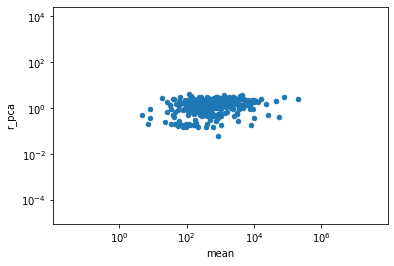

In [142]:
import matplotlib.pyplot as plt
df.plot.scatter(x="mean", y="r_pca", logy=True, logx=True)
plt.show()

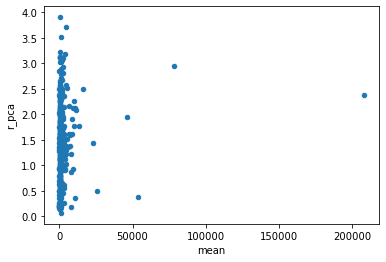

In [143]:
df.plot.scatter(x="mean", y="r_pca", logy=False, logx=False)
plt.show()

In [146]:
df_adj = df[df["mean"]<10000]

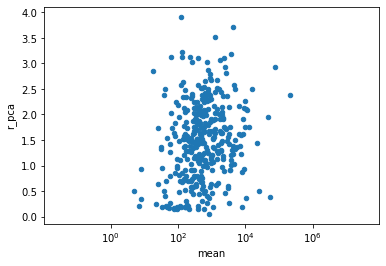

In [144]:
df.plot.scatter(x="mean", y="r_pca", logy=False, logx=True)
plt.show()

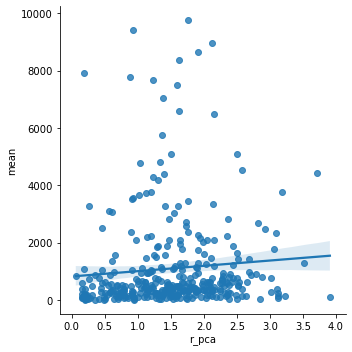

In [147]:
import seaborn as sns
sns.lmplot(x='r_pca',y='mean',data=df_adj,fit_reg=True)
plt.show()

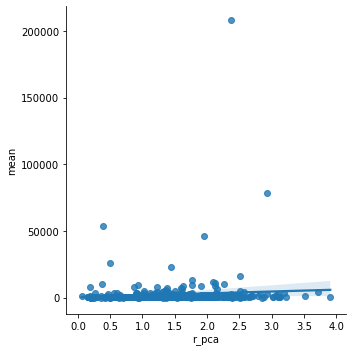

In [148]:
sns.lmplot(x='r_pca',y='mean',data=df,fit_reg=True)
plt.show()

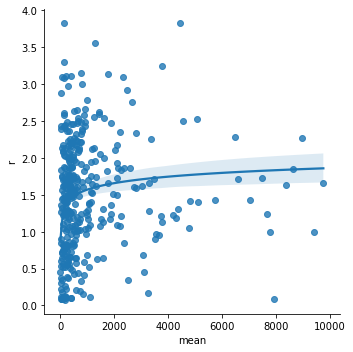

In [88]:
sns.lmplot(x='mean',y='r',data=df_adj,fit_reg=True, logx=True)
plt.show()

# We conclude that they are not :(